In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
%matplotlib inline
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.autograd import Variable
import os

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
batch_size = 128
epochs = 300
learning_rate = 0.001

In [3]:
if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')

In [4]:



def load_dataset():
    data_path = '/datasets_1/sagarj/satellite/training_6_cities/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
    ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [5]:
def to_img(x):
    x = x.view(x.size(0), 3, 64, 64)
    return x

In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 16, 5, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1),
            nn.BatchNorm2d(16),
            
            nn.Conv2d(16, 32, 7, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 7,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=1),
            
            nn.Conv2d(32, 32, 9,stride=2,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.Conv2d(32, 32, 9,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, 9,stride=1,padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 9,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 7,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 7, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 5, stride=1, padding=0),
            nn.Sigmoid()
        )
        
#         self.encoder_fc = nn.Sequential(#a set of FC layers
#             nn.Linear(batch_size*64*10*10, 512),
#             nn.ReLU(True),
#         )
        
#         self.decoder_fc = nn.Sequential(
#             nn.Linear(512,batch_size*64*10*10),
#             nn.ReLU(True),
#         )
        
       

    def forward(self, x , compressed = False):
        #encode
        x_comp = self.encoder(x) 
#         shape = x_comp.shape
#         x_comp = self.encoder_fc(x_comp.flatten())
#         print(x_comp.size())
        #decode
#         x_recon = self.decoder_fc(x_comp)
#         x_recon = x_recon.reshape(shape)
        x_recon = self.decoder(x_comp)
#         print(x_recon.size())
        
        if compressed:
            return x_comp.detach() , x_recon
        else:
            return x_recon

In [7]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [8]:
dataloader = load_dataset()

In [9]:
# dataloader.sampler.data_source.samples

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7EFCBBD66A20>


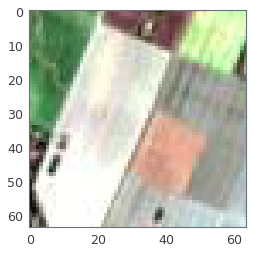

In [10]:
len(dataloader.dataset)
with open(dataloader.sampler.data_source.samples[1][0], 'rb') as f:
    img = Image.open(f)
    plt.grid()
    plt.imshow(img)
    print(img)

In [16]:
for epoch in range(10):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cuda()
#         print(img.shape)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, epochs, loss.data))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './dc_img/image_{}.jpg'.format(epoch))

epoch [1/300], loss:0.0139
epoch [2/300], loss:0.0144
epoch [3/300], loss:0.0149
epoch [4/300], loss:0.0145
epoch [5/300], loss:0.0155
epoch [6/300], loss:0.0148
epoch [7/300], loss:0.0163
epoch [8/300], loss:0.0152
epoch [9/300], loss:0.0140
epoch [10/300], loss:0.0138


In [17]:
torch.save(model.state_dict(), './conv_autoencoder_trained_on_sentinel_512.pth')

In [27]:
model.forward(img[1].unsqueeze(0)).cpu()

TypeError: 'JpegImageFile' object does not support indexing

In [14]:
# model = autoencoder().cuda()
# model.load_state_dict(torch.load('./conv_autoencoder_trained_on_sentinel_small.pth'))
# model.eval()

In [19]:
from glob import glob
Sat_Images = glob('/datasets_1/sagarj/satellite/training_6_cities/*/*.jpg')

In [29]:
#Storage dictionary
scaler = transforms.Resize((64, 64))
to_tensor = transforms.ToTensor()
features = {'imageName':[] , 'feature':[]}
model.eval()
print("Extracting features from %d images",len(Sat_Images))
for i in tqdm(range(len(Sat_Images))):
    name = Sat_Images[i].split('/')[-1]
    img = Image.open(Sat_Images[i])  
    t_img = Variable(to_tensor(scaler(img))).unsqueeze(0).cuda() 
    code , gen_X = model.forward(t_img , compressed = True)
    
    features['imageName'].append(name)
    features['feature'].append(code.detach().cpu().numpy().squeeze().flatten())

  0%|          | 28/8416 [00:00<00:30, 274.16it/s]

Extracting features from %d images 8416


100%|██████████| 8416/8416 [00:17<00:00, 471.85it/s]


In [30]:
import pandas as pd 
Italy_features = pd.DataFrame.from_dict(features)

In [31]:
len(Italy_features.iloc[1]['feature'])

512

In [32]:
Italy_features

,imageName,feature
0,S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_2...,"[-0.49638134, 0.112570934, -0.030250652, -0.12..."
1,S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_2...,"[1.0101085, -0.38798743, -0.21142615, 0.184020..."
2,S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_2...,"[1.7322872, -0.09343558, -0.83630687, 0.064558..."
3,S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_2...,"[1.0732123, 0.75754523, -0.2863385, -0.2867083..."
4,S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_2...,"[-0.11289966, 0.526387, 0.3751173, 0.3424982, ..."
...,...,...
8411,S2A_MSIL2A_20181023T100051_N0209_R122_T32TQM_2...,"[1.8884357, 1.2368355, 0.3333782, -0.5551255, ..."
8412,S2A_MSIL2A_20181023T100051_N0209_R122_T32TQM_2...,"[0.784602, 0.7548764, 0.32152185, -0.8440884, ..."
8413,S2A_MSIL2A_20181023T100051_N0209_R122_T32TQM_2...,"[-0.91861683, -0.70486397, -0.25862882, 0.3019..."
8414,S2A_MSIL2A_20181023T100051_N0209_R122_T32TQM_2...,"[-0.54376346, 0.78654414, -0.013742484, 0.2077..."


In [33]:
Italy_features.to_json('6cities_AEC_512_flattened.json')

In [34]:
resnet_features = Italy_features
n_components = 64
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n_features = len(resnet_features.loc[0, 'feature'])
resnet_features = resnet_features.set_index("imageName")

rf = resnet_features.copy()

rf[['f'+str(i) for i in range(n_features)]] = \
	pd.DataFrame(rf.feature.values.tolist(), \
	index= rf.index)

rf = rf.drop(columns=['feature'])
print (rf.head())

standardized_features = StandardScaler().fit_transform(rf)
print (standardized_features)

standardized_features_df = pd.DataFrame(standardized_features)

rf=rf.reset_index()

resnet_features_standardized = pd.concat([ rf["imageName"], standardized_features_df], axis = 1)

print (resnet_features_standardized)

resnet_features_standardized = resnet_features_standardized.set_index("imageName")

                                                          f0        f1  \
imageName                                                                
S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_20... -0.496381  0.112571   
S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_20...  1.010108 -0.387987   
S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_20...  1.732287 -0.093436   
S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_20...  1.073212  0.757545   
S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_20... -0.112900  0.526387   

                                                          f2        f3  \
imageName                                                                
S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_20... -0.030251 -0.123284   
S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_20... -0.211426  0.184020   
S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_20... -0.836307  0.064559   
S2B_MSIL2A_20181024T102059_N0209_R065_T32TLQ_20... -0.286339 -0.286708   
S2B_MSIL2A_20181024T102059_N0209_R065

In [35]:
pca = PCA(n_components=n_components)
pca.fit(resnet_features_standardized)

pca_df = pd.DataFrame(pca.transform(resnet_features_standardized), \
	columns=['PCA%i' % i for i in range(n_components)],\
	index=resnet_features_standardized.index)

print (pca.explained_variance_ratio_)
print (sum(pca.explained_variance_ratio_), len(pca.explained_variance_ratio_))


[0.08300846 0.04985344 0.01891969 0.0173117  0.01516723 0.013925
 0.01213786 0.01166777 0.01104124 0.01035967 0.00992798 0.00938509
 0.00897746 0.00858681 0.00841796 0.00811276 0.00771045 0.00756677
 0.00742781 0.00719831 0.00705638 0.00684192 0.00680927 0.00662786
 0.00651596 0.00644367 0.00621861 0.00612057 0.00584784 0.00581191
 0.00569184 0.00558534 0.00555185 0.00545425 0.0053526  0.00531432
 0.00520004 0.00508838 0.00502362 0.00495001 0.00479019 0.00473687
 0.00469373 0.00460349 0.00452036 0.00447013 0.00441966 0.00435518
 0.00429058 0.00420285 0.00411058 0.00400433 0.00398452 0.00393629
 0.00389925 0.0038712  0.00379343 0.00368241 0.00365562 0.0036188
 0.00356699 0.00352459 0.00344641 0.00341582]
0.5418029358248573 64
